# `如何使用機器學習提高房仲業潛在成交率_系列3_提升機器學習準確度的方法`
## 作者：陳政廷、王裕萍、謝豐檍(臺灣行銷研究特邀作者)、鍾皓軒(臺灣行銷研究有限公司創辦人）

## 原始資料請見[本連結](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data)，下載下來後與本ipynb檔案放於同一個工作目錄中，再執行下方程式即可

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

## 系列1_資料前處理

In [2]:
df_train=pd.read_json(open(r"train.json"))
#系列1_資料前處理
df_train["num_photos"]=df_train["photos"].apply(len)
df_train["num_description_words"]=df_train["description"].apply(lambda x:len(x.split(" "))) #根據空白切割，去算字數
def caculate(n_words):
    description_test=[]
    for i in n_words:
        description_test.append(len(i.split(" ")))
    return description_test #效果和上面一樣
df_train["created"]=pd.to_datetime(df_train["created"])
df_train["created_year"]=df_train["created"].dt.year
df_train["created_month"] = df_train["created"].dt.month
df_train["created_day"] = df_train["created"].dt.day

## 系列2_特徵處理：篩選頻率大於100之字詞

In [4]:
bigdic = {}
for i in df_train['features']:
    for word in i:
        if word not in bigdic:
            bigdic[word] = 1
        else:
            bigdic[word] += 1
data = {'word': [*bigdic], 'number': [*bigdic.values()]}   
bigdf = pd.DataFrame.from_dict(data).sort_values(by='number', ascending=False)
keyword = bigdf[bigdf['number'] > 100]['word'].to_list()
print(keyword)
#
def get_dummy(keyword, alist):
    countlist = []
    for row in df_train['features']:
        if keyword in row:
            countlist.append(1)
        else:
            countlist.append(0)
    df_train[keyword] = countlist
for word in keyword:
    get_dummy(word, df_train['features'])
#
choose_columns=["bathrooms", "bedrooms", "latitude", "longitude","num_photos","price",'Elevator', 'Cats Allowed', 'Hardwood Floors', 'Dogs Allowed', 'Doorman', 'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center', 'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony', 'Swimming Pool', 'Laundry In Building', 'New Construction', 'Terrace', 'Exclusive', 'Loft', 'Garden/Patio', 'Wheelchair Access', 'Common Outdoor Space', 'HARDWOOD', 'Fireplace', 'SIMPLEX', 'prewar', 'LOWRISE', 'Garage', 'Laundry Room', 'Reduced Fee', 'Laundry In Unit', 'Furnished', 'Multi-Level', 'Private Outdoor Space', 'Prewar', 'PublicOutdoor', 'Parking Space', 'Roof-deck', 'dishwasher', 'High Ceilings', 'elevator', 'Renovated', 'Pool', 'LAUNDRY', 'Green Building', 'HIGH CEILINGS', 'LIVE IN SUPER', 'High Ceiling', 'Washer in Unit', 'Dryer in Unit', 'Storage', 'Stainless Steel Appliances', 'On-site laundry', 'Concierge', 'Newly renovated', 'On-site Laundry', 'Live In Super', 'Hardwood', 'Light', 'On-site Garage', 'Washer/Dryer', 'Granite Kitchen', 'Gym/Fitness', 'Pets on approval', 'Marble Bath', 'Walk in Closet(s)']

['Elevator', 'Cats Allowed', 'Hardwood Floors', 'Dogs Allowed', 'Doorman', 'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center', 'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony', 'Swimming Pool', 'Laundry In Building', 'New Construction', 'Terrace', 'Exclusive', 'Loft', 'Garden/Patio', 'Wheelchair Access', 'Common Outdoor Space', 'HARDWOOD', 'Fireplace', 'SIMPLEX', 'prewar', 'LOWRISE', 'Garage', 'Laundry Room', 'Reduced Fee', 'Laundry In Unit', 'Furnished', 'Multi-Level', 'Private Outdoor Space', 'Prewar', 'PublicOutdoor', 'Parking Space', 'Roof-deck', 'dishwasher', 'High Ceilings', 'elevator', 'Renovated', 'Pool', 'LAUNDRY', 'Green Building', 'HIGH CEILINGS', 'LIVE IN SUPER', 'High Ceiling', 'Washer in Unit', 'Dryer in Unit', 'Storage', 'Stainless Steel Appliances', 'On-site laundry', 'Concierge', 'Newly renovated', 'On-site Laundry', 'Live In Super', 'Hardwood', 'Light', 'On-site Garage', 'Washer/Dryer', 'Granite K

## RF：特徵篩選、處理資料不平衡、標準化、模型訓練

In [5]:
#rf
X=df_train[choose_columns]
Y=df_train["interest_level"]
#
rf = RandomForestClassifier().fit(X,Y)		
for feature in zip(choose_columns, rf.feature_importances_):
    print((feature))

selector = SelectFromModel(rf,prefit = True,threshold=0.01)
print("Features selected by SelectFromModel: "
      f"{np.array(choose_columns)[selector.get_support()]}")
X = X[np.array(choose_columns)[selector.get_support()]]
#
X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(X, Y, test_size=0.2, random_state = 0)

('bathrooms', 0.017768422525377005)
('bedrooms', 0.05463170284019433)
('latitude', 0.14568002755453535)
('longitude', 0.14665677807303595)
('num_photos', 0.11409114797713595)
('price', 0.21399025371326022)
('Elevator', 0.015494179023249163)
('Cats Allowed', 0.013177384912528463)
('Hardwood Floors', 0.01814602068571681)
('Dogs Allowed', 0.01272031701043776)
('Doorman', 0.012324687051087108)
('Dishwasher', 0.01450163846274891)
('No Fee', 0.021380424903113766)
('Laundry in Building', 0.013187840666037875)
('Fitness Center', 0.010442289064350716)
('Pre-War', 0.017170513676233956)
('Laundry in Unit', 0.013450144740020804)
('Roof Deck', 0.008958321794154888)
('Outdoor Space', 0.009682180831576799)
('Dining Room', 0.010668200823891055)
('High Speed Internet', 0.006652990221845295)
('Balcony', 0.007136565147027542)
('Swimming Pool', 0.0051919059855988735)
('Laundry In Building', 0.00940162518184341)
('New Construction', 0.005515949069650801)
('Terrace', 0.005549835036192719)
('Exclusive', 0.00

High: 27470
Medium: 27470
Low: 27470


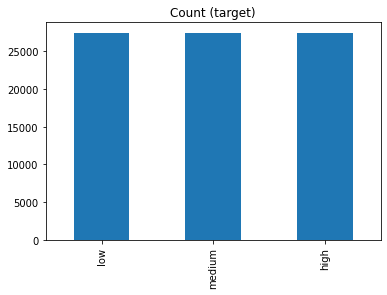

In [6]:
#RandomOverSampler=ros
train = pd.concat([X_train_rf, Y_train_rf], axis = 1)
valid = pd.concat([X_test_rf, Y_test_rf], axis = 1)
high = train[train["interest_level"] == 'high']
medium = train[train["interest_level"] == 'medium']
low = train[train["interest_level"] == 'low']
df_high = high.sample(len(low),replace=True)
df_med = medium.sample(len(low),replace=True)
#
train_ros = pd.concat([df_high,df_med,low],axis = 0)
train_ros = train_ros.sample(frac=1)
X_train_ros_rf = train_ros[X.columns]
Y_train_rf_ros = train_ros['interest_level']
#
target_count = train_ros.interest_level.value_counts()
print('High:', target_count['high'])
print('Medium:', target_count['medium'])
print('Low:', target_count['low'])
target_count.plot(kind='bar', title='Count (target)');
#標準化
regression_col_rf = ["bathrooms", "bedrooms", "latitude", "longitude","num_photos","price"]
classification_col_rf = ['Elevator','Cats Allowed','Hardwood Floors','Dogs Allowed','Doorman','Dishwasher','No Fee','Laundry in Building','Pre-War','Laundry in Unit','Dining Room']
sc_rf = StandardScaler()
X_train_rf_r = sc_rf.fit_transform(X_train_ros_rf[regression_col_rf])#
X_test_rf_r = sc_rf.transform(X_test_rf[regression_col_rf])#
X_train_rf_r = pd.DataFrame(X_train_rf_r).reset_index(drop=True)
X_test_rf_r = pd.DataFrame(X_test_rf_r).reset_index(drop=True)
X_train_rf_c = X_train_ros_rf[classification_col_rf].reset_index(drop=True)#
X_test_rf_c = X_test_rf[classification_col_rf].reset_index(drop=True)
X_train_rf_ros = pd.concat([X_train_rf_r, X_train_rf_c],axis=1)
X_test_rf_ros = pd.concat([X_test_rf_r, X_test_rf_c], axis = 1)

In [7]:
#Smote
X_train_smote_rf, Y_train_smote_rf = SMOTE().fit_sample(X_train_rf, Y_train_rf)
print(Y_train_smote_rf.value_counts()) # 確認資料平衡
#
train_smote = pd.concat([X_train_smote_rf, Y_train_smote_rf],axis = 1)
train_smote = train_smote.sample(frac=1)
X_train_smote_rf_df = train_smote[X.columns]
X_test_rf_smote=X_test_rf[X.columns]
Y_train_smote_rf = train_smote['interest_level']
#標準化
sc = StandardScaler()
X_train_smote_r = sc.fit_transform(X_train_smote_rf_df[regression_col_rf])
X_test_smote_r = sc.transform(X_test_rf_smote[regression_col_rf])
X_train_smote_r = pd.DataFrame(X_train_smote_r).reset_index(drop=True)
X_test_smote_r = pd.DataFrame(X_test_smote_r).reset_index(drop=True)
X_train_smote_c = X_train_smote_rf_df[classification_col_rf].reset_index(drop=True)
X_test_smote_c = X_test_rf_smote[classification_col_rf].reset_index(drop=True)
#
X_train_smote_rf = pd.concat([X_train_smote_r, X_train_smote_c],axis=1)
X_test_smote_rf = pd.concat([X_test_smote_r, X_test_smote_c], axis = 1)

low       27470
medium    27470
high      27470
Name: interest_level, dtype: int64


High: 26310
Medium: 26532
Low: 27470


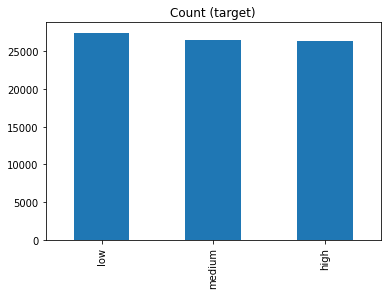

In [8]:
#Adasyn
X_train_adasyn_rf, Y_train_adasyn_rf = ADASYN().fit_sample(X_train_rf, Y_train_rf)
#
target_count = Y_train_adasyn_rf.value_counts()
print('High:', target_count['high'])
print('Medium:', target_count['medium'])
print('Low:', target_count['low'])
target_count.plot(kind='bar', title='Count (target)');
#
train_adasyn = pd.concat([X_train_adasyn_rf, Y_train_adasyn_rf],axis = 1)
train_adasyn = train_adasyn.sample(frac=1)
X_train_adasyn_rf_df = train_adasyn[X.columns]
X_test_rf_adasyn=X_test_rf[X.columns]
Y_train_adasyn_rf = train_adasyn['interest_level']
#標準化
sc = StandardScaler()
X_train_adasyn_r = sc.fit_transform(X_train_adasyn_rf_df[regression_col_rf])
X_test_adasyn_r = sc.transform(X_test_rf_adasyn[regression_col_rf])
X_train_adasyn_r = pd.DataFrame(X_train_adasyn_r).reset_index(drop=True)
X_test_adasyn_r = pd.DataFrame(X_test_adasyn_r).reset_index(drop=True)
X_train_adasyn_c = X_train_adasyn_rf_df[classification_col_rf].reset_index(drop=True)
X_test_adasyn_c = X_test_rf_adasyn[classification_col_rf].reset_index(drop=True)
#
X_train_adasyn_rf = pd.concat([X_train_adasyn_r, X_train_adasyn_c],axis=1)
X_test_adasyn_rf = pd.concat([X_test_adasyn_r, X_test_adasyn_c], axis = 1)

In [9]:
#implement model
#RandomOverSampler
clf_ros_rf= RandomForestClassifier(n_estimators=200,max_depth=13 ,random_state=0)
clf_ros_rf.fit(X_train_rf_ros, Y_train_rf_ros)
print('Log loss on training_ros_rf dataset: ',log_loss(Y_train_rf_ros, clf_ros_rf.predict_proba(X_train_rf_ros)))
print('Log loss on testing_ros_rf dataset: ',log_loss(Y_test_rf, clf_ros_rf.predict_proba(X_test_rf_ros)))
#Smote
clf_smote_rf= RandomForestClassifier(n_estimators=200,max_depth=13 ,random_state=0)
clf_smote_rf.fit(X_train_smote_rf, Y_train_smote_rf)
print('Log loss on training_smote_rf dataset: ',log_loss(Y_train_smote_rf, clf_smote_rf.predict_proba(X_train_smote_rf)))
print('Log loss on testing_smote_rf dataset: ',log_loss(Y_test_rf, clf_smote_rf.predict_proba(X_test_smote_rf)))
#Adasyn
clf_adasyn_rf= RandomForestClassifier(n_estimators=200,max_depth=13 ,random_state=0)
clf_adasyn_rf.fit(X_train_adasyn_rf, Y_train_adasyn_rf)
print('Log loss on training_rf dataset: ',log_loss(Y_train_adasyn_rf, clf_adasyn_rf.predict_proba(X_train_adasyn_rf)))
print('Log loss on testing_rf dataset: ',log_loss(Y_test_rf, clf_adasyn_rf.predict_proba(X_test_adasyn_rf)))

Log loss on training_ros_rf dataset:  0.642044089983792
Log loss on testing_ros_rf dataset:  0.7651352483748638
Log loss on training_smote_rf dataset:  0.7128857021801258
Log loss on testing_smote_rf dataset:  0.7979174140389498
Log loss on training_rf dataset:  0.7313767407770981
Log loss on testing_rf dataset:  0.8012699042073906


## XGB：特徵篩選、處理資料不平衡、標準化、模型訓練

In [10]:
#xgb
X=df_train[choose_columns]
Y=df_train["interest_level"]
#
xgb = xgb.XGBClassifier().fit(X,Y)		
for feature in zip(choose_columns, xgb.feature_importances_):
    print((feature))

selector = SelectFromModel(xgb,prefit = True,threshold=0.02)
print("Features selected by SelectFromModel: "
      f"{np.array(choose_columns)[selector.get_support()]}")
X = X[np.array(choose_columns)[selector.get_support()]]
#
X_train_xgb, X_test_xgb, Y_train_xgb, Y_test_xgb = train_test_split(X, Y, test_size=0.2, random_state = 0)

('bathrooms', 0.023299037)
('bedrooms', 0.05728956)
('latitude', 0.03170791)
('longitude', 0.025688747)
('num_photos', 0.06463715)
('price', 0.07509823)
('Elevator', 0.015026101)
('Cats Allowed', 0.0)
('Hardwood Floors', 0.13670494)
('Dogs Allowed', 0.015412761)
('Doorman', 0.009637335)
('Dishwasher', 0.030747833)
('No Fee', 0.09060067)
('Laundry in Building', 0.012489352)
('Fitness Center', 0.0062987907)
('Pre-War', 0.016118981)
('Laundry in Unit', 0.009111703)
('Roof Deck', 0.0016712534)
('Outdoor Space', 0.015450262)
('Dining Room', 0.011479532)
('High Speed Internet', 0.0)
('Balcony', 0.0022401984)
('Swimming Pool', 0.012119083)
('Laundry In Building', 0.04607277)
('New Construction', 0.0010066461)
('Terrace', 0.008725449)
('Exclusive', 0.024789108)
('Loft', 0.0039733807)
('Garden/Patio', 0.0025406785)
('Wheelchair Access', 0.0053706365)
('Common Outdoor Space', 0.0136557575)
('HARDWOOD', 0.072352126)
('Fireplace', 0.0028062335)
('SIMPLEX', 0.025450023)
('prewar', 0.0)
('LOWRISE', 

In [11]:
#RandomOverSampler=ros
train = pd.concat([X_train_xgb, Y_train_xgb], axis = 1)
valid = pd.concat([X_test_xgb, Y_test_xgb], axis = 1)
high = train[train["interest_level"] == 'high']
medium = train[train["interest_level"] == 'medium']
low = train[train["interest_level"] == 'low']
df_high = high.sample(len(low),replace=True)
df_med = medium.sample(len(low),replace=True)
#
train_ros = pd.concat([df_high,df_med,low],axis = 0)
train_ros = train_ros.sample(frac=1)
X_train_ros_xgb = train_ros[X.columns]
Y_train_xgb_ros = train_ros['interest_level']
#標準化
regression_col_xgb = ["bathrooms", "bedrooms", "latitude", "longitude","num_photos","price"]
classification_col_xgb = ['Hardwood Floors','Dishwasher','No Fee','Laundry In Building','Exclusive','HARDWOOD','SIMPLEX','Reduced Fee','Furnished']
sc_xgb = StandardScaler()
X_train_xgb_r = sc_xgb.fit_transform(X_train_ros_xgb[regression_col_xgb])#
X_test_xgb_r = sc_xgb.transform(X_test_xgb[regression_col_xgb])#
X_train_xgb_r = pd.DataFrame(X_train_xgb_r).reset_index(drop=True)
X_test_xgb_r = pd.DataFrame(X_test_xgb_r).reset_index(drop=True)
X_train_xgb_c = X_train_ros_xgb[classification_col_xgb].reset_index(drop=True)#
X_test_xgb_c = X_test_xgb[classification_col_xgb].reset_index(drop=True)
X_train_xgb_ros = pd.concat([X_train_xgb_r, X_train_xgb_c],axis=1)
X_test_xgb_ros = pd.concat([X_test_xgb_r, X_test_xgb_c], axis = 1)

In [12]:
#Smote
X_train_smote_xgb, Y_train_smote_xgb = SMOTE().fit_sample(X_train_xgb, Y_train_xgb)
print(Y_train_smote_xgb.value_counts()) # 確認資料平衡
#
train_smote = pd.concat([X_train_smote_xgb, Y_train_smote_xgb],axis = 1)
train_smote = train_smote.sample(frac=1)
X_train_smote_xgb_df = train_smote[X.columns]
X_test_xgb_smote=X_test_xgb[X.columns]
Y_train_smote_xgb = train_smote['interest_level']
#標準化
sc = StandardScaler()
X_train_smote_r = sc.fit_transform(X_train_smote_xgb_df[regression_col_xgb])
X_test_smote_r = sc.transform(X_test_xgb_smote[regression_col_xgb])
X_train_smote_r = pd.DataFrame(X_train_smote_r).reset_index(drop=True)
X_test_smote_r = pd.DataFrame(X_test_smote_r).reset_index(drop=True)
X_train_smote_c = X_train_smote_xgb_df[classification_col_xgb].reset_index(drop=True)
X_test_smote_c = X_test_xgb_smote[classification_col_xgb].reset_index(drop=True)
#
X_train_smote_xgb = pd.concat([X_train_smote_r, X_train_smote_c],axis=1)
X_test_smote_xgb = pd.concat([X_test_smote_r, X_test_smote_c], axis = 1)

low       27470
medium    27470
high      27470
Name: interest_level, dtype: int64


In [13]:
#Adasyn
X_train_adasyn_xgb, Y_train_adasyn_xgb = ADASYN().fit_sample(X_train_xgb, Y_train_xgb)
#
train_adasyn = pd.concat([X_train_adasyn_xgb, Y_train_adasyn_xgb],axis = 1)
train_adasyn = train_adasyn.sample(frac=1)
X_train_adasyn_xgb_df = train_adasyn[X.columns]
X_test_xgb_adasyn=X_test_xgb[X.columns]
Y_train_adasyn_xgb = train_adasyn['interest_level']
#標準化
sc = StandardScaler()
X_train_adasyn_r = sc.fit_transform(X_train_adasyn_xgb_df[regression_col_xgb])
X_test_adasyn_r = sc.transform(X_test_xgb_adasyn[regression_col_xgb])
X_train_adasyn_r = pd.DataFrame(X_train_adasyn_r).reset_index(drop=True)
X_test_adasyn_r = pd.DataFrame(X_test_adasyn_r).reset_index(drop=True)
X_train_adasyn_c = X_train_adasyn_xgb_df[classification_col_xgb].reset_index(drop=True)
X_test_adasyn_c = X_test_xgb_adasyn[classification_col_xgb].reset_index(drop=True)
#
X_train_adasyn_xgb = pd.concat([X_train_adasyn_r, X_train_adasyn_c],axis=1)
X_test_adasyn_xgb = pd.concat([X_test_adasyn_r, X_test_adasyn_c], axis = 1)

In [14]:
#implement model
#RandomOverSampler
import xgboost as xgb
clf_ros_xgb= xgb.XGBClassifier(n_estimators=200,max_depth=4 ,random_state=0)
clf_ros_xgb.fit(X_train_xgb_ros, Y_train_xgb_ros)
print('Log loss on training_ros_xgb dataset: ',log_loss(Y_train_xgb_ros, clf_ros_xgb.predict_proba(X_train_xgb_ros)))
print('Log loss on testing_ros_xgb dataset: ',log_loss(Y_test_xgb, clf_ros_xgb.predict_proba(X_test_xgb_ros)))
#Smote
clf_smote_xgb= xgb.XGBClassifier(n_estimators=200,max_depth=4 ,random_state=0)
clf_smote_xgb.fit(X_train_smote_xgb, Y_train_smote_xgb)
print('Log loss on training_smote_xgb dataset: ',log_loss(Y_train_smote_xgb, clf_smote_xgb.predict_proba(X_train_smote_xgb)))
print('Log loss on testing_smote_xgb dataset: ',log_loss(Y_test_xgb, clf_smote_xgb.predict_proba(X_test_smote_xgb)))
#Adasyn
clf_adasyn_xgb= xgb.XGBClassifier(n_estimators=200,max_depth=4 ,random_state=0)
clf_adasyn_xgb.fit(X_train_adasyn_xgb, Y_train_adasyn_xgb)
print('Log loss on training_adasyn_xgb dataset: ',log_loss(Y_train_adasyn_xgb, clf_adasyn_xgb.predict_proba(X_train_adasyn_xgb)))
print('Log loss on testing_adasyn_xgb dataset: ',log_loss(Y_test_xgb, clf_adasyn_xgb.predict_proba(X_test_adasyn_xgb)))

Log loss on training_ros_xgb dataset:  0.7588317269697792
Log loss on testing_ros_xgb dataset:  0.7642013800874667
Log loss on training_smote_xgb dataset:  0.7895954880433267
Log loss on testing_smote_xgb dataset:  0.791326814292148
Log loss on training_adasyn_xgb dataset:  0.8142764306815977
Log loss on testing_adasyn_xgb dataset:  0.8050816519765595


## LGBM：特徵篩選、處理資料不平衡、標準化、模型訓練

In [15]:
#lgb
X=df_train[choose_columns]
Y=df_train["interest_level"]
#
lgb = lgb.LGBMClassifier().fit(X,Y)	
for feature in zip(choose_columns, lgb.feature_importances_):
    print((feature))

selector = SelectFromModel(lgb,prefit = True,threshold=80)
print("Features selected by SelectFromModel: "
      f"{np.array(choose_columns)[selector.get_support()]}")
X = X[np.array(choose_columns)[selector.get_support()]]
#
X_train_lgb, X_test_lgb, Y_train_lgb, Y_test_lgb = train_test_split(X, Y, test_size=0.2, random_state = 0)

('bathrooms', 230)
('bedrooms', 806)
('latitude', 1655)
('longitude', 1456)
('num_photos', 602)
('price', 1824)
('Elevator', 95)
('Cats Allowed', 69)
('Hardwood Floors', 103)
('Dogs Allowed', 63)
('Doorman', 47)
('Dishwasher', 79)
('No Fee', 205)
('Laundry in Building', 90)
('Fitness Center', 55)
('Pre-War', 122)
('Laundry in Unit', 84)
('Roof Deck', 30)
('Outdoor Space', 65)
('Dining Room', 48)
('High Speed Internet', 33)
('Balcony', 63)
('Swimming Pool', 46)
('Laundry In Building', 125)
('New Construction', 34)
('Terrace', 52)
('Exclusive', 73)
('Loft', 36)
('Garden/Patio', 22)
('Wheelchair Access', 44)
('Common Outdoor Space', 27)
('HARDWOOD', 69)
('Fireplace', 16)
('SIMPLEX', 10)
('prewar', 6)
('LOWRISE', 3)
('Garage', 11)
('Laundry Room', 4)
('Reduced Fee', 78)
('Laundry In Unit', 60)
('Furnished', 114)
('Multi-Level', 15)
('Private Outdoor Space', 55)
('Prewar', 2)
('PublicOutdoor', 3)
('Parking Space', 28)
('Roof-deck', 5)
('dishwasher', 11)
('High Ceilings', 16)
('elevator', 19

In [16]:
#RandomOverSampler=ros
train = pd.concat([X_train_lgb, Y_train_lgb], axis = 1)
valid = pd.concat([X_test_lgb, Y_test_lgb], axis = 1)
high = train[train["interest_level"] == 'high']
medium = train[train["interest_level"] == 'medium']
low = train[train["interest_level"] == 'low']
df_high = high.sample(len(low),replace=True)
df_med = medium.sample(len(low),replace=True)
#
train_ros = pd.concat([df_high,df_med,low],axis = 0)
train_ros = train_ros.sample(frac=1)
X_train_ros_lgb = train_ros[X.columns]
Y_train_lgb_ros = train_ros['interest_level']
#標準化
regression_col_lgb= ["bathrooms", "bedrooms", "latitude", "longitude","num_photos","price"]
classification_col_lgb = [ 'Elevator', 'Hardwood Floors', 'No Fee','Pre-War', 'Laundry In Building', 'Furnished']
sc_lgb = StandardScaler()
X_train_lgb_r = sc_lgb.fit_transform(X_train_ros_lgb[regression_col_lgb])#
X_test_lgb_r = sc_lgb.transform(X_test_lgb[regression_col_lgb])#
X_train_lgb_r = pd.DataFrame(X_train_lgb_r).reset_index(drop=True)
X_test_lgb_r = pd.DataFrame(X_test_lgb_r).reset_index(drop=True)
X_train_lgb_c = X_train_ros_lgb[classification_col_lgb].reset_index(drop=True)#
X_test_lgb_c = X_test_lgb[classification_col_lgb].reset_index(drop=True)
X_train_lgb_ros = pd.concat([X_train_lgb_r, X_train_lgb_c],axis=1)
X_test_lgb_ros = pd.concat([X_test_lgb_r, X_test_lgb_c], axis = 1)

In [17]:
#Smote
X_train_smote_lgb, Y_train_smote_lgb = SMOTE().fit_sample(X_train_lgb, Y_train_lgb)
print(Y_train_smote_lgb.value_counts()) # 確認資料平衡
#
train_smote = pd.concat([X_train_smote_lgb, Y_train_smote_lgb],axis = 1)
train_smote = train_smote.sample(frac=1)
X_train_smote_lgb_df = train_smote[X.columns]
X_test_lgb_smote=X_test_lgb[X.columns]
Y_train_smote_lgb = train_smote['interest_level']
#標準化
sc = StandardScaler()
X_train_smote_r = sc.fit_transform(X_train_smote_lgb_df[regression_col_lgb])
X_test_smote_r = sc.transform(X_test_lgb_smote[regression_col_lgb])
X_train_smote_r = pd.DataFrame(X_train_smote_r).reset_index(drop=True)
X_test_smote_r = pd.DataFrame(X_test_smote_r).reset_index(drop=True)
X_train_smote_c = X_train_smote_lgb_df[classification_col_lgb].reset_index(drop=True)
X_test_smote_c = X_test_lgb_smote[classification_col_lgb].reset_index(drop=True)
#
X_train_smote_lgb = pd.concat([X_train_smote_r, X_train_smote_c],axis=1)
X_test_smote_lgb = pd.concat([X_test_smote_r, X_test_smote_c], axis = 1)

low       27470
medium    27470
high      27470
Name: interest_level, dtype: int64


In [18]:
#Adasyn
X_train_adasyn_lgb, Y_train_adasyn_lgb = ADASYN().fit_sample(X_train_lgb, Y_train_lgb)
#
train_adasyn = pd.concat([X_train_adasyn_lgb, Y_train_adasyn_lgb],axis = 1)
train_adasyn = train_adasyn.sample(frac=1)
X_train_adasyn_lgb_df = train_adasyn[X.columns]
X_test_lgb_adasyn=X_test_lgb[X.columns]
Y_train_adasyn_lgb = train_adasyn['interest_level']
#標準化
sc = StandardScaler()
X_train_adasyn_r = sc.fit_transform(X_train_adasyn_lgb_df[regression_col_lgb])
X_test_adasyn_r = sc.transform(X_test_lgb_adasyn[regression_col_lgb])
X_train_adasyn_r = pd.DataFrame(X_train_adasyn_r).reset_index(drop=True)
X_test_adasyn_r = pd.DataFrame(X_test_adasyn_r).reset_index(drop=True)
X_train_adasyn_c = X_train_adasyn_lgb_df[classification_col_lgb].reset_index(drop=True)
X_test_adasyn_c = X_test_lgb_adasyn[classification_col_lgb].reset_index(drop=True)
#
X_train_adasyn_lgb = pd.concat([X_train_adasyn_r, X_train_adasyn_c],axis=1)
X_test_adasyn_lgb = pd.concat([X_test_adasyn_r, X_test_adasyn_c], axis = 1)

In [19]:
#implement model
#RandomOverSampler
import lightgbm as lgb
clf_ros_lgb= lgb.LGBMClassifier(random_state=0)
clf_ros_lgb.fit(X_train_lgb_ros, Y_train_lgb_ros)
print('Log loss on training_ros_lgb dataset: ',log_loss(Y_train_lgb_ros, clf_ros_lgb.predict_proba(X_train_lgb_ros)))
print('Log loss on testing_ros_lgb dataset: ',log_loss(Y_test_lgb, clf_ros_lgb.predict_proba(X_test_lgb_ros)))
#Smote
clf_smote_lgb= lgb.LGBMClassifier(random_state=0)
clf_smote_lgb.fit(X_train_smote_lgb, Y_train_smote_lgb)
print('Log loss on training_smote_lgb dataset: ',log_loss(Y_train_smote_lgb, clf_smote_lgb.predict_proba(X_train_smote_lgb)))
print('Log loss on testing_smote_lgb dataset: ',log_loss(Y_test_lgb, clf_smote_lgb.predict_proba(X_test_smote_lgb)))
#Adasyn
clf_adasyn_lgb= lgb.LGBMClassifier(random_state=0)
clf_adasyn_lgb.fit(X_train_adasyn_lgb, Y_train_adasyn_lgb)
print('Log loss on training_adasyn_lgb dataset: ',log_loss(Y_train_adasyn_lgb, clf_adasyn_lgb.predict_proba(X_train_adasyn_lgb)))
print('Log loss on testing_adasyn_lgb dataset: ',log_loss(Y_test_lgb, clf_adasyn_lgb.predict_proba(X_test_adasyn_lgb)))

Log loss on training_ros_lgb dataset:  0.692840919545154
Log loss on testing_ros_lgb dataset:  0.7363600111671159
Log loss on training_smote_lgb dataset:  0.7257956967684569
Log loss on testing_smote_lgb dataset:  0.7565473261752504
Log loss on training_adasyn_lgb dataset:  0.7462440554978343
Log loss on testing_adasyn_lgb dataset:  0.7607797993667978
